<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/16_music_classification_pro_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация музыки по жанрам

1. Выполните задание light.
2. Получите визуальные представления аудио файлов (возможно длительности менее 30 секунд).
3. Постройте модель классификации с использованием сверточных сетей. 
Удалось ли превзойти полносвязные сети?

# Подготовка окружения

In [0]:
# feature extractoring and preprocessing data
import librosa
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#matplotlib inline
import os
import PIL
from IPython.display import display
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# Google
from google.colab import files
from google.colab import drive


#Keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

def cv2_imshow(a):
    """A replacement for cv2.imshow() for use in Jupyter notebooks."""
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(a))
        
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

slice_duration = 5
pics_folder = f"genres_pics_{slice_duration}"

## Подключение Google Drive

In [2]:
drive.mount('/content/drive')
#http://marsyas.info/downloads/datasets.html

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Загрузка наборов данных

## Скачивание наборов данных

### Оригинальный набор данных

In [0]:
!cp /content/drive/'My Drive'/neural/genres.zip genres.zip
!unzip genres.zip

### Спектрограммы

In [0]:
!cp /content/drive/'My Drive'/neural/genres_pics.zip genres_pics.zip
!unzip genres_pics.zip

## Преобразование оригинального набора данных в спектрограммы

### Создание дерева папок

In [18]:
print(pics_folder)
!rm -fr {pics_folder}
!mkdir {pics_folder}

!mkdir {pics_folder}/train
!mkdir {pics_folder}/val
!mkdir {pics_folder}/test

for category in ["train", "val", "test"]:
    for genre in genres:
        path = f'{pics_folder}/{category}/{genre}'
        if not os.path.isdir(path):
            os.makedirs(path)

genres_pics_5


### Cпектрограммы первых 5 секунд

In [63]:
cmap = plt.get_cmap('inferno')
validation_split = 0.1
test_split = 0.1

plt.figure(figsize=(10,10))
for genre in genres:
    genredir = os.listdir(f'./genres/{genre}')
    
    val_threshold = round(len(genredir) * (1 - validation_split - test_split))
    test_threshold = round(len(genredir) * (1 - test_split))
    print(f"[{genre}], {len(genredir)} files, split: 0-{val_threshold}-{test_threshold}")
    
    category = "train"
    
    i = 0
    for filename in genredir:
        songname = f'./genres/{genre}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'{pics_folder}/{category}/{genre}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
        
        i += 1
        if i >= test_threshold:
            category = "test"
        elif i >= val_threshold:
            category = "val"

[hiphop], 100 files, split: 0-80-90
[jazz], 100 files, split: 0-80-90
[metal], 100 files, split: 0-80-90
[pop], 100 files, split: 0-80-90
[reggae], 100 files, split: 0-80-90
[rock], 100 files, split: 0-80-90


<Figure size 720x720 with 0 Axes>

### Cпектрограммы всех 5-секундных интервалов

In [12]:
np.arange(0, 30 // slice_duration)

array([0, 1, 2, 3, 4, 5])

In [20]:
cmap = plt.get_cmap('inferno')
validation_split = 0.1
test_split = 0.1

plt.figure(figsize=(10,10))

parts = np.arange(0, 30 // slice_duration)

for genre in genres:
    genredir = os.listdir(f'./genres/{genre}')
    files_count = len(genredir)
    
    val_threshold = round(files_count * (1 - validation_split - test_split))
    test_threshold = round(files_count * (1 - test_split))
    print()
    print(f"[{genre}], {files_count} files, split: 0-{val_threshold}-{test_threshold}")
    
    category = "train"
    
    i = 0
    for filename in genredir:
        songname = f'./genres/{genre}/{filename}'
        print("\r", end = f'{genre}: {i} of {files_count}, {category}')
        for part in parts:
            y, sr = librosa.load(songname, mono=True, offset = part * slice_duration, duration=slice_duration)

            plt.specgram(y, NFFT=512, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
            plt.axis('off');
            plt.savefig(f'{pics_folder}/{category}/{genre}/{filename[:-3].replace(".", "")}_{part}.png', dpi=30)
            plt.clf()

        i += 1
        if i >= test_threshold:
            category = "test"
        elif i >= val_threshold:
            category = "val"

[blues], 100 files, split: 0-80-90
blues: 99 of 100, test[classical], 100 files, split: 0-80-90
classical: 99 of 100, test[country], 100 files, split: 0-80-90
country: 99 of 100, test[disco], 100 files, split: 0-80-90
disco: 99 of 100, test[hiphop], 100 files, split: 0-80-90
hiphop: 99 of 100, test[jazz], 100 files, split: 0-80-90
jazz: 99 of 100, test[metal], 100 files, split: 0-80-90
metal: 99 of 100, test[pop], 100 files, split: 0-80-90
pop: 99 of 100, test[reggae], 100 files, split: 0-80-90
reggae: 99 of 100, test[rock], 100 files, split: 0-80-90
rock: 99 of 100, test

<Figure size 720x720 with 0 Axes>

In [72]:
print("Genre train images: ", len(os.listdir(f'{pics_folder}/train/{genre}')))
print("Genre val images: ", len(os.listdir(f'{pics_folder}/val/{genre}')))
print("Genre test images: ", len(os.listdir(f'{pics_folder}/test/{genre}')))


Train images:  81
Val images:  10
Test images:  9


### Сохранение архива

In [0]:
print(pics_folder)
!zip -r {pics_folder}.zip {pics_folder}

### Просмотр спектрограмм

(300, 300, 4)


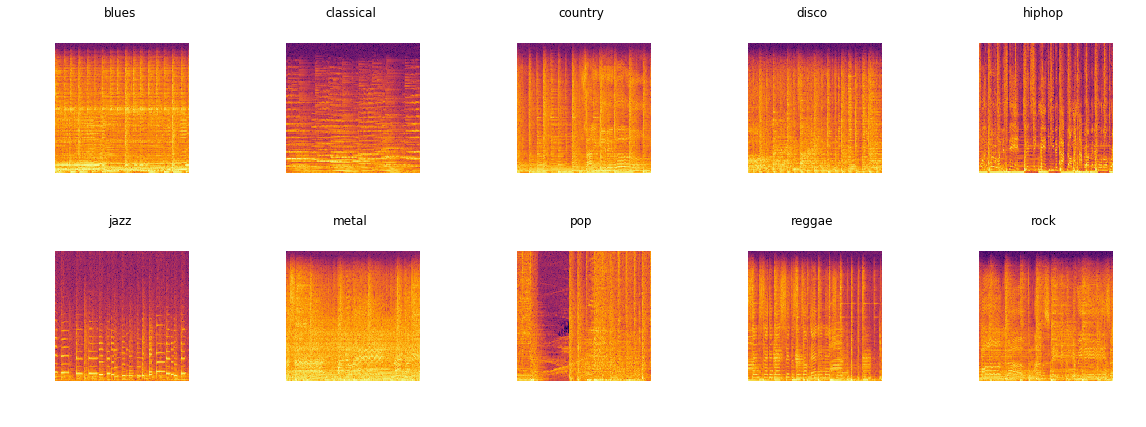

In [21]:
import matplotlib.image as mpimg
fig, axes = plt.subplots(2, 5, figsize=(20, 7))

i = 0
for row in np.arange(2):
    for col in np.arange(5):
        genre = genres[i]
        sample_file = os.listdir(f'{pics_folder}/train/{genre}')[25]
        
        ax = axes[row][col]
        ax.axis('off')
        ax.set_title(genre)
        img = mpimg.imread(f"{pics_folder}/train/{genre}/{sample_file}")
        ax.imshow(img)
        i += 1
        
print(img.shape)

# Обучение нейросети

## Генератор

In [53]:
batch_size= 10
image_rows = 300
image_cols = 300
image_channels = 3

train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    f'{pics_folder}/train',
    target_size=(image_rows, image_cols),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(
    f'{pics_folder}/val',
    target_size=(image_rows, image_cols),
    batch_size=batch_size,
    class_mode='categorical')

steps_per_epoch = train_generator.samples / batch_size
val_steps_per_epoch = val_generator.samples / batch_size

Found 4800 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


## Нейросеть

Found 4800 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1_130 ( (None, 300, 300, 3)       12        
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 300, 300, 32)      896       
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_v1_131 ( (None, 75, 75, 32)        128       
_________________________________________________________

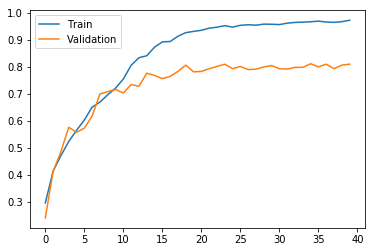

In [65]:
from tensorflow.keras import callbacks
# from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    f'{pics_folder}/train',
    target_size=(image_rows, image_cols),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(
    f'{pics_folder}/val',
    target_size=(image_rows, image_cols),
    batch_size=batch_size,
    class_mode='categorical')

steps_per_epoch = train_generator.samples / batch_size
val_steps_per_epoch = val_generator.samples / batch_size

model_callbacks = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00005, verbose=1)
]

model = Sequential()
model.add(BatchNormalization(input_shape=(image_rows, image_cols, image_channels)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              validation_data = val_generator,
                              validation_steps = val_steps_per_epoch,
                              epochs=40,
                              callbacks=model_callbacks
                              )

plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.legend()
plt.show()

## Проверка модели на тестовом наборе данных

In [66]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    f'{pics_folder}/test',
    target_size=(image_rows, image_cols),
    batch_size=batch_size,
    class_mode='categorical')


result = model.evaluate_generator(
    test_generator, 
    steps = test_generator.samples // batch_size,
    verbose = 1)
print(result)

Found 600 images belonging to 10 classes.
60/60 [==============================] - 3s 46ms/step - loss: 0.9801 - acc: 0.8000
[0.9800952649364869, 0.8]
